## Enhance LLMs using RAG and Hugging Face

In [20]:
!pip uninstall -y numpy torch transformers trl datasets faiss-cpu
!pip install numpy==1.25.2
!pip install torch==2.2.2 torchvision==0.17.2 --index-url https://download.pytorch.org/whl/cu121
!pip install transformers==4.36.2 datasets==2.18.0 faiss-cpu wget trl==0.7.9

In [21]:
import wget
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
import torch

import numpy as np
import random
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
# from transformers import AutoTokenizer, AutoModelForCausalLM


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import numpy as np

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

### Helper Function

In [2]:
def tsne_plot(data):
    tsne = TSNE(n_components=3, random_state=42,perplexity=data.shape[0]-1)
    data_3d = tsne.fit_transform(data)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    num_points = len(data_3d)
    colors = plt.cm.tab20(np.linspace(0, 1, num_points))

    for idx, point in enumerate(data_3d):
        ax.scatter(point[0], point[1], point[2], label=str(idx), color=colors[idx])

    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization')
    plt.legend(title='Input Order')
    plt.show()

### Load and Preprocess Data

In [3]:
filename = 'companyPolicies.txt'
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/6JDbUb_L3egv_eOkouY71A.txt'

wget.download(url, out=filename)
print('file downloaded')

file downloaded


In [4]:
def read_and_split_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    paragraphs = text.split('\n')
    paragraphs = [para.strip() for para in paragraphs if len(para.strip()) > 0]
    return paragraphs

paragraphs = read_and_split_text('companyPolicies.txt')
paragraphs[0:3]

['1.\tCode of Conduct',
 'Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.',
 'Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest.']

### Building the Retriever: Encoding and Indexing

#### Encoding Texts into Embeddings

In [5]:
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
random.shuffle(paragraphs)

Sample paragraphs to show in t-SNE plot

In [7]:
tokens=context_tokenizer( paragraphs[:20], return_tensors='pt', padding=True, truncation=True, max_length=256)
outputs=context_encoder(**tokens)
outputs.pooler_output

tensor([[ 0.5488,  0.3156,  0.5122,  ..., -0.3317, -0.5188, -0.0304],
        [ 0.2495,  0.0156,  0.0455,  ..., -0.3945, -0.7374, -0.1193],
        [ 0.3164, -0.2672,  0.0067,  ...,  0.1750, -0.3381,  0.4668],
        ...,
        [ 0.3538,  0.6022,  0.1236,  ..., -0.7121, -0.7073, -0.1449],
        [ 0.6975,  0.5583,  0.1917,  ..., -0.6279, -0.4837, -0.1460],
        [ 0.6344,  0.5021,  0.4597,  ..., -0.2579, -0.4885,  0.3274]],
       grad_fn=<SliceBackward0>)

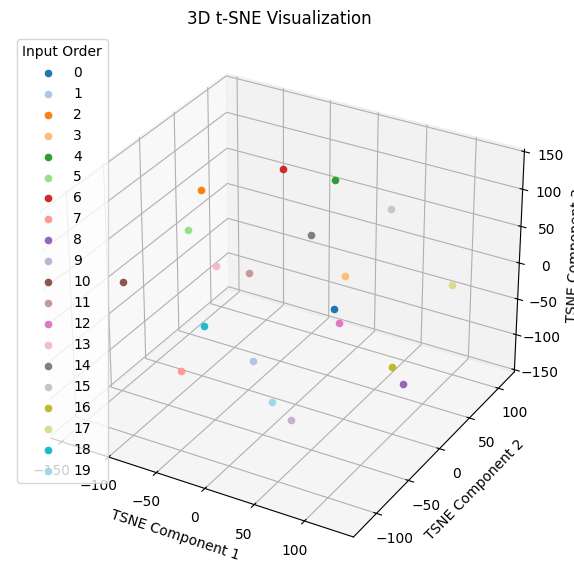

In [8]:
tsne_plot(outputs.pooler_output.detach().numpy())

In [9]:
def encode_contexts(text_list):
    embeddings = []
    for text in text_list:
        inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        outputs = context_encoder(**inputs)
        embeddings.append(outputs.pooler_output)
    return torch.cat(embeddings).detach().numpy()

context_embeddings = encode_contexts(paragraphs)

#### Creating and Populating the FAISS Index

In [10]:
import faiss

embedding_dim = 768
context_embeddings_np = np.array(context_embeddings).astype('float32')

index = faiss.IndexFlatL2(embedding_dim)
index.add(context_embeddings_np)

### DPR Question Encoder and Tokenizer

In [11]:
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.weight', 'question_encoder.bert_model.pooler.dense.bias']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Example Query and Context Retrieval

In [12]:
question = 'Drug and Alcohol Policy'
question_inputs = question_tokenizer(question, return_tensors='pt')
question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

D, I = index.search(question_embedding, k=5)
print("D:",D)
print("I:",I)

D: [[72.76533  74.7162   84.38811  88.364365 90.28711 ]]
I: [[67 18 25  2  0]]


In [13]:
print("Top 5 relevant contexts:")
for i, idx in enumerate(I[0]):
    print(f"{i+1}: {paragraphs[idx]}")
    print(f"distance {D[0][i]}\n")

Top 5 relevant contexts:
1: 6.	Drug and Alcohol Policy
distance 72.76532745361328

2: Policy Objective: The Drug and Alcohol Policy is established to establish clear expectations and guidelines for the responsible use of drugs and alcohol within the organization. This policy aims to maintain a safe, healthy, and productive workplace.
distance 74.71620178222656

3: Testing and Searches: The organization reserves the right to conduct drug and alcohol testing as per applicable laws and regulations. Employees may be subject to testing in cases of reasonable suspicion, post-accident, or as part of routine workplace safety measures.
distance 84.38810729980469

4: 9.	Discipline and Termination Policy
distance 88.36436462402344

5: Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.
distance 90.287109375



In [14]:
def search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5):
    """
    Searches for the most relevant contexts to a given question.

    Returns:
    tuple: Distances and indices of the top k relevant contexts.
    """
    question_inputs = question_tokenizer(question, return_tensors='pt')
    question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()
    D, I = index.search(question_embedding, k)
    return D, I

### Enhancing Response Generation with LLMs

In [15]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
model.generation_config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

#### Comparing Answer Generation:
With and Without DPR Contexts

In [16]:
def generate_answer_without_context(question):
    inputs = tokenizer(question, return_tensors='pt', max_length=1024, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0,
                                 num_beams=5, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    answer = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return answer

def generate_answer(question, contexts):
    input_text = question + ' ' + ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_new_tokens=50, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [17]:
question = "what is mobile policy?"
answer = generate_answer_without_context(question)

print("Generated Answer without DPR:", answer)

Generated Answer without DPR: what is mobile policy?

Mobile policy is a set of policies that govern the use of mobile devices. Mobile policy is a set of policies that govern the use of mobile devices. Mobile policy is a set of policies that govern the use of mobile devices. Mobile policy is a set of policies that govern the use of mobile devices. Mobile policy is a set of policies that govern the use of mobile devices. Mobile policy is a set of policies that govern the use of mobile devices. Mobile policy is a set of policies that govern the use of mobile devices. Mobile policy is a set of policies that govern the use of mobile devices. Mobile policy is a set of policies that govern the use of mobile devices. Mobile policy is a set of policies that


In [18]:
_,I =search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)
top_contexts = [paragraphs[idx] for idx in I[0]]
answer = generate_answer(question, top_contexts)
print("Generated Answer with DPR:", answer)

Generated Answer with DPR: what is mobile policy? 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.

The Mobile Phone Policy sets fort

### Tuning Generation Parameters in GPT2

In [19]:
def generate_answer(contexts, max_len=50, min_len=40, length_penalty=2.0, num_beams=4):
    input_text = ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    summary_ids = model.generate(
        inputs['input_ids'],
        max_new_tokens=max_len,
        min_length=min_len,
        length_penalty=length_penalty,
        num_beams=num_beams,
        early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

question = "what is mobile policy?"

_, I = search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)
top_contexts = [paragraphs[idx] for idx in I[0]]

settings = [(50, 50, 1.0, 2),(120, 30, 2.0, 4),(100, 20, 2.5, 6)]

for setting in settings:
    answer = generate_answer(top_contexts, *setting)
    print(f"Settings: max_new_tokens={setting[0]}, min_length={setting[1]}, length_penalty={setting[2]}, num_beams={setting[3]}")
    print("Generated Answer:", answer)
    print("\n" + "="*80 + "\n")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Settings: max_new_tokens=50, min_length=50, length_penalty=1.0, num_beams=2
Generated Answer: 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best p

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Settings: max_new_tokens=120, min_length=30, length_penalty=2.0, num_beams=4
Generated Answer: 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best 